# Initial Preparation

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.4 is required in this notebook
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.4"

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()
np.random.seed(42)
tf.random.set_seed(42)

# For changes
USER = "ageent"
REPO = "y-mlOnPhrases"
SKIP_FLAG = "fm1_0"    # Maybe "tm1", "tm2", "fm1_0" ... or "all"

X_FILE = "X.npy"
Y1_FILE = "Y1.npy"
Y2_FILE = "Y2.npy"

In [2]:
# to save data or images
if "google.colab" in sys.modules:
    from google.colab import drive
    ROOT_GD = "/content/drive"
    STORAGE_PATH = ROOT_GD + "/My Drive/Colab Notebooks/" + REPO + "/"
    drive.mount(ROOT_GD)
else:   # local host
    STORAGE_PATH = "data/"

def save_data(prefix, file_name, data_frame):
    path = STORAGE_PATH + prefix + file_name
    data_frame.to_csv(path)

def save_pred(file_name, data_frame):
    save_data("predictions/", file_name, data_frame)
def save_trans_data(file_name, data_frame):
    save_data("transformed/", file_name, data_frame)

"""
fig, ax = plt.subplots()
ax.plot(data)
save_fig(fig, "fig_name")
"""
def save_fig(fig_id, fig=plt, tight_layout=True, fig_extension="png", resolution=300):
    path = STORAGE_PATH + "img/" + fig_id + "." + fig_extension
    print("Saving figure", fig_id)
    if tight_layout:
        fig.tight_layout()
    fig.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
# get the data
def get_github_data(path_to_file):
    """TODO: maybe need to use requests."""
    url = "https://raw.githubusercontent.com/{}/{}/{}"\
                            .format(USER, REPO, path_to_file)
    return np.load(url)

def get_localhost_data(file_name):
    path = "data/src/" + file_name
    return np.load(path)

if "google.colab" in sys.modules:
    PATH_TO_SRC = "main/data/src/"
    X_DATA = get_github_data(PATH_TO_SRC + X_FILE)
    Y1_DATA = get_github_data(PATH_TO_SRC + Y1_FILE)
    Y2_DATA = get_github_data(PATH_TO_SRC + Y2_FILE)
else:   # local host
    X_DATA = get_localhost_data(X_FILE)
    Y1_DATA = get_localhost_data(Y1_FILE)
    Y2_DATA = get_localhost_data(Y2_FILE)

In [4]:
print(X_DATA.shape)
print(X_DATA[0])

(800, 128)
[-0.98200285  5.3519163   0.6241017  -3.7863977  -2.0433748  -1.6433135
  5.0111694   0.11501709 -3.3202858   2.2631938   4.487829    3.1017983
  3.4887044  -4.942223    6.474518    0.77631605  5.3201113  -5.003155
 -6.0889516   3.9606059   4.9673815   0.5534823   2.3377123  -3.4211032
  5.278324    1.576092   -5.2838745   0.5925345  -1.2432728   1.5591371
 -1.0380139  -0.1521509   2.4624774   6.4752107  -4.399489   -2.6032155
  3.5712152   0.44489035  1.3303515   0.42398357  2.2737198   7.777598
 -3.3040464  -2.2658207  -7.7937617  -0.6868003   7.5321355   0.5417963
  2.423962    7.1077695  -0.6353128   3.4406264  -2.3372521   0.1237992
  1.9296596   4.452048    2.1478891  -2.770266   -9.235324   10.521325
 -8.574103   -3.127737   -5.1270823   5.001681   -2.710712    0.44150203
 -0.15498942  0.24662127 -0.21252623 -1.7166231  -1.0460446  -5.4344797
  2.56957    10.698443   -3.0771906   1.0651661  -0.32124305  5.725385
  7.167192    5.156452    5.6941953   6.4998055   6.7241

In [5]:
print(Y1_DATA.shape)
print(Y1_DATA[0:10])

(800,)
[1 2 2 0 1 0 2 2 1 0]


In [6]:
print(Y2_DATA.shape)
print(Y2_DATA[0:10])

(800,)
[ 6. 15. 34. 58. 27. 29. 50. 12.  7. 17.]


# Feature engineering
### Transforming

In [7]:
x = X_DATA.copy()
y2 = Y2_DATA.copy()

In [8]:
from sklearn.preprocessing import OneHotEncoder

transformer_y1 = OneHotEncoder()

In [9]:
y1 = transformer_y1.fit_transform(Y1_DATA[:, np.newaxis]).toarray()
y1

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

### Shuffle

In [10]:
t_ = np.hstack([x, y1, y2[:, np.newaxis]])
t_.shape

(800, 132)

In [11]:
np.random.shuffle(t_)
x = t_[:, :128].copy()
y1 = t_[:, 128:131].copy()
y2 = t_[:, 131].copy()
y = tf.concat([y1, y2[:, tf.newaxis]], axis=1)
%reset_selective -f t_

# Model selection
### Model 1
Сoefficient w_cl in loss1 is 1.0.
#### Loss and metrics

In [12]:
def classifier_metric(y_true, y_pred):
    return keras.metrics.categorical_accuracy(y_true[:, :3], y_pred)

def regressor_metric(y_true, y_pred):
    y_true_reg = tf.cast(y_true[:, 3], tf.float32)
    y_pred = tf.cast(y_pred, tf.float64)
    w_reg = 1 / 3
    y_pred_w = tf.cast(y_pred * w_reg, tf.float32)
    y_pred_reg = tf.reduce_sum(y_pred_w, axis=1)
    return tf.metrics.mean_squared_error(y_true_reg, y_pred_reg)

In [13]:
# test for metrics
y_true_ = tf.constant([[1, 0, 0, 60],
                       [0 ,1, 0, 50],
                       [0, 0, 1, 20],
                       [0, 1, 0, 4]])
y_pred_ = tf.constant([[99, 0, 0],
                       [0, 99, 0],
                       [0, 99, 9],
                       [0, 99, 0]])
print(classifier_metric(y_true_, y_pred_))
print(regressor_metric(y_true_, y_pred_))

tf.Tensor([1. 1. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(528.75, shape=(), dtype=float32)


In [14]:
def get_summands(y_true, y_pred, w_cl=1.):
    y_true_cl_ = tf.cast(y_true[:, :3], tf.float32)
    y_true_reg_ = tf.cast(y_true[:, 3], tf.float32)
    y_pred_ = tf.cast(y_pred, tf.float32)

    # classification
    y_pred_max = tf.reduce_max(y_pred_, axis=1)[:, tf.newaxis]
    y_pred_norm = y_pred_ / y_pred_max
    ss_cl = tf.square(y_true_cl_ - y_pred_norm) * w_cl

    # regression
    w_reg = 1 / 3
    y_pred_w = tf.cast(y_pred_ * w_reg, tf.float32)
    y_pred_reg = tf.reduce_sum(y_pred_w, axis=1)
    ss_reg = tf.square(y_true_reg_ - y_pred_reg)

    return tf.concat([ss_cl, ss_reg[:, tf.newaxis]], 1)

def loss1(y_true, y_pred):
    summands = get_summands(y_true, y_pred, 1.)
    return tf.reduce_sum(summands)

In [15]:
# test for loss1
y_true_ = tf.constant([[1, 0, 0, 60],
                       [0 ,1, 0, 50],
                       [2, 0, 1, 20],
                       [0, 1, 0, 4]])
y_pred_ = tf.constant([[99, 0, 0],
                       [0, 99, 0],
                       [1, 0, 99],
                       [0, 99, 0]])
loss1(y_true_, y_pred_)

<tf.Tensor: shape=(), dtype=float32, numpy=2040.7374>

#### Create model

In [16]:
if SKIP_FLAG.find("tm1") != -1 or SKIP_FLAG.find("all") != -1:
    model1 = keras.models.Sequential()
    model1.add(keras.layers.Dense(3, activation="linear", use_bias=False, input_shape=[128]))
    model1.compile(loss=loss1,
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=[classifier_metric, regressor_metric])
    history1 = model1.fit(x, y, epochs=300, validation_split=0.2)

### Model 2

In [17]:
def loss2(y_true, y_pred):
    summands = get_summands(y_true, y_pred)
    cl_mul = tf.reduce_sum(summands[:, :3], axis=1)
    reg_mul = summands[:, 3]
    return tf.reduce_sum(cl_mul * reg_mul)

In [18]:
# test for loss2
y_true_ = tf.constant([[1, 0, 0, 60],
                       [0 ,1, 0, 50],
                       [2, 0, 1, 20],
                       [0, 1, 0, 4]])
y_pred_ = tf.constant([[99, 0, 0],
                       [0, 99, 0],
                       [1, 0, 99],
                       [0, 99, 0]])
loss2(y_true_, y_pred_)

<tf.Tensor: shape=(), dtype=float32, numpy=703.9462>

In [19]:
if SKIP_FLAG.find("tm2") != -1 or SKIP_FLAG.find("all") != -1:
    model2 = keras.models.Sequential()
    model2.add(keras.layers.Dense(3, activation="linear", use_bias=False, input_shape=[128]))
    model2.compile(loss=loss2,
                   optimizer=tf.keras.optimizers.Adam(learning_rate=1e-1),
                   metrics=[classifier_metric, regressor_metric])
    history2 = model2.fit(x, y, epochs=30, validation_split=0.2)

### Model 3

In [20]:
def loss3(y_true, y_pred):
    y_true_cl_ = tf.cast(y_true[:, :3], tf.float32)
    y_true_reg_ = tf.cast(y_true[:, 3], tf.float32)
    y_pred_ = tf.cast(y_pred, tf.float32)

    # classification
    y_pred_max = tf.reduce_max(y_pred_, axis=1)[:, tf.newaxis]
    y_pred_norm = y_pred_ / y_pred_max
    ss_cl = tf.square(y_true_cl_ - y_pred_norm)

    # regression
    w_reg = 1 / 3
    thr = tf.sqrt(2.)
    y_pred_w = tf.cast(y_pred_ * w_reg, tf.float32)
    y_pred_reg = tf.reduce_sum(y_pred_w, axis=1)
    delta_reg = y_true_reg_ - y_pred_reg
    is_more_threshold = delta_reg >= thr
    big_grad = tf.square(2. * delta_reg - thr)
    small_grad = tf.square((1/2) * delta_reg) + 1.5
    ss_reg = tf.where(is_more_threshold, big_grad, small_grad)
    summands = tf.concat([ss_cl, ss_reg[:, tf.newaxis]], 1)

    return tf.reduce_sum(summands)

In [21]:
# test for loss3
y_true_ = tf.constant([[1, 0, 0, 60],
                       [0 ,1, 0, 50],
                       [2, 0, 1, 20],
                       [0, 1, 0, 4]])
y_pred_ = tf.constant([[99, 0, 0],
                       [0, 99, 0],
                       [1, 0, 99],
                       [0, 99, 0]])
loss3(y_true_, y_pred_)

<tf.Tensor: shape=(), dtype=float32, numpy=4088.7522>

In [22]:
if SKIP_FLAG.find("tm3") != -1 or SKIP_FLAG.find("all") != -1:
    model3 = keras.models.Sequential()
    model3.add(keras.layers.Dense(3, activation="linear", use_bias=False, input_shape=[128]))
    model3.compile(loss=loss3,
                   optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
                   metrics=[classifier_metric, regressor_metric])
    history3 = model3.fit(x, y, epoch=200, validation_split=0.2)

# Setting up the model
Model 1 selected.

In [23]:
def loss1_w(w_cl=1.):
    def loss1_(y_true, y_pred):
        summands = get_summands(y_true, y_pred, w_cl)
        return tf.reduce_sum(summands)
    return loss1_

### Final model 1.0

In [36]:
if SKIP_FLAG.find("fm1_0") != -1 or SKIP_FLAG.find("all") != -1:
    finmod1_0 = keras.models.Sequential()
    finmod1_0.add(keras.layers.Dense(3, activation="linear", use_bias=False, input_shape=[128]))
    finmod1_0.compile(loss=loss1_w(),
                      optimizer=keras.optimizers.Adam(learning_rate=1e-2),
                      metrics=[classifier_metric, regressor_metric])
    history1_0 = finmod1_0.fit(x, y, epochs=100, validation_split=0.2, batch_size=16)

Epoch 1/100
40/40 [==============================] - 6s 40ms/step - loss: 3562.8628 - classifier_metric: 0.3250 - regressor_metric: 220.9781 - val_loss: 374.9240 - val_classifier_metric: 0.3812 - val_regressor_metric: 22.3540
Epoch 2/100
40/40 [==============================] - 0s 5ms/step - loss: 177.0305 - classifier_metric: 0.3250 - regressor_metric: 9.9159 - val_loss: 115.3935 - val_classifier_metric: 0.3812 - val_regressor_metric: 6.1427
Epoch 3/100
40/40 [==============================] - 0s 7ms/step - loss: 98.3443 - classifier_metric: 0.3250 - regressor_metric: 5.0068 - val_loss: 82.9131 - val_classifier_metric: 0.3812 - val_regressor_metric: 4.1165
Epoch 4/100
40/40 [==============================] - 0s 6ms/step - loss: 76.3080 - classifier_metric: 0.3250 - regressor_metric: 3.6324 - val_loss: 74.3041 - val_classifier_metric: 0.3812 - val_regressor_metric: 3.5816
Epoch 5/100
40/40 [==============================] - 0s 6ms/step - loss: 67.4696 - classifier_metric: 0.3281 - regr

In [37]:
if SKIP_FLAG.find("fm1_0") != -1 or SKIP_FLAG.find("all") != -1:
    finmod1_0.compile(loss=loss1_w(),
                   optimizer=keras.optimizers.Adam(learning_rate=1e-2),
                   metrics=[classifier_metric, regressor_metric])
    history1_0a = finmod1_0.fit(x, y, epochs=100, validation_split=0.2, batch_size=32)

Epoch 1/100
20/20 [==============================] - 2s 34ms/step - loss: 556.8781 - classifier_metric: 0.7266 - regressor_metric: 16.7336 - val_loss: 496.8579 - val_classifier_metric: 0.7312 - val_regressor_metric: 14.8405
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 156.6871 - classifier_metric: 0.7281 - regressor_metric: 4.2293 - val_loss: 84.5724 - val_classifier_metric: 0.7312 - val_regressor_metric: 1.9831
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 61.8993 - classifier_metric: 0.7328 - regressor_metric: 1.2690 - val_loss: 68.7042 - val_classifier_metric: 0.7312 - val_regressor_metric: 1.4883
Epoch 4/100
20/20 [==============================] - 0s 3ms/step - loss: 51.7181 - classifier_metric: 0.7375 - regressor_metric: 0.9528 - val_loss: 59.9102 - val_classifier_metric: 0.7437 - val_regressor_metric: 1.2202
Epoch 5/100
20/20 [==============================] - 0s 3ms/step - loss: 53.6742 - classifier_metric: 0.7422 - regress

In [38]:
if SKIP_FLAG.find("fm1_0") != -1 or SKIP_FLAG.find("all") != -1:
    finmod1_0.compile(loss=loss1_w(),
                   optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                   metrics=[classifier_metric, regressor_metric])
    history1_0aa = finmod1_0.fit(x, y, epochs=100, validation_split=0.2, batch_size=320)

Epoch 1/100
2/2 [==============================] - 4s 906ms/step - loss: 637.5496 - classifier_metric: 0.9469 - regressor_metric: 1.5800 - val_loss: 336.1816 - val_classifier_metric: 0.9000 - val_regressor_metric: 1.6497
Epoch 2/100
2/2 [==============================] - 0s 78ms/step - loss: 600.6785 - classifier_metric: 0.9469 - regressor_metric: 1.4745 - val_loss: 333.6007 - val_classifier_metric: 0.9000 - val_regressor_metric: 1.6337
Epoch 3/100
2/2 [==============================] - 0s 94ms/step - loss: 506.2515 - classifier_metric: 0.9469 - regressor_metric: 1.1775 - val_loss: 295.7425 - val_classifier_metric: 0.9000 - val_regressor_metric: 1.3918
Epoch 4/100
2/2 [==============================] - 0s 94ms/step - loss: 443.5981 - classifier_metric: 0.9469 - regressor_metric: 0.9766 - val_loss: 346.1390 - val_classifier_metric: 0.9000 - val_regressor_metric: 1.7037
Epoch 5/100
2/2 [==============================] - 0s 63ms/step - loss: 489.6585 - classifier_metric: 0.9469 - regresso

Saving figure mod1.0_loss1


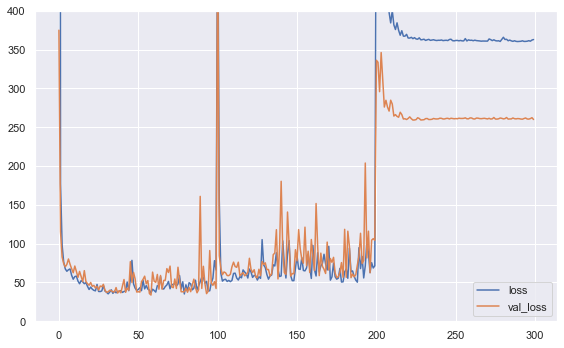

In [39]:
if SKIP_FLAG.find("fm1_0") != -1 or SKIP_FLAG.find("all") != -1:
    df_h1_0 = pd.concat([pd.DataFrame(history1_0.history),
                         pd.DataFrame(history1_0a.history),
                         pd.DataFrame(history1_0aa.history)], ignore_index=True)
    df_h1_0.iloc[:, [0, 3]].plot(figsize=(8, 5))
    plt.gca().set_ylim(0, 400)
    save_fig("mod1.0_loss1")

Saving figure mod1.0_clMetric


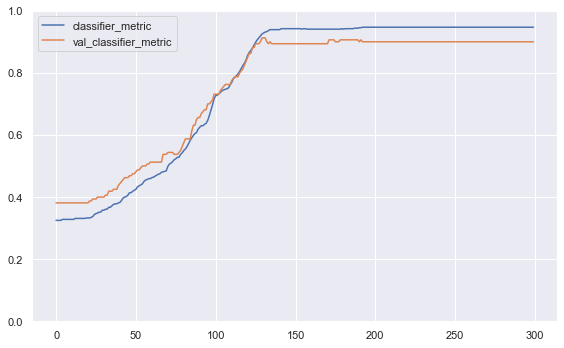

In [40]:
if SKIP_FLAG.find("fm1_0") != -1 or SKIP_FLAG.find("all") != -1:
    df_h1_0.iloc[:, [1, 4]].plot(figsize=(8, 5))
    plt.gca().set_ylim(0, 1)
    save_fig("mod1.0_clMetric")

Saving figure mod1.0_regMetric


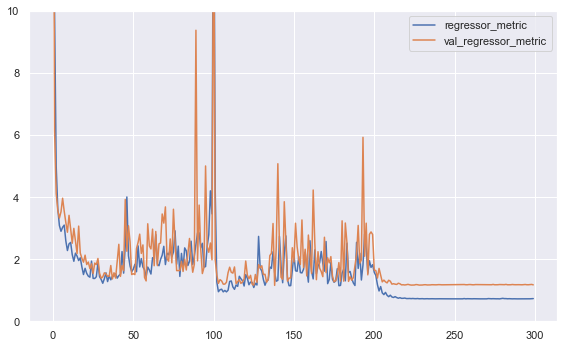

In [41]:
if SKIP_FLAG.find("fm1_0") != -1 or SKIP_FLAG.find("all") != -1:
    df_h1_0.iloc[:, [2, 5]].plot(figsize=(8, 5))
    plt.gca().set_ylim(0, 10)
    save_fig("mod1.0_regMetric")

### Final model 1.1

In [42]:
if SKIP_FLAG.find("fm1_1") != -1 or SKIP_FLAG.find("all") != -1:
    finmod1_1 = keras.models.Sequential()
    finmod1_1.add(keras.layers.Dense(3, activation="linear", use_bias=False, input_shape=[128]))
    finmod1_1.compile(loss=loss1_w(tf.sqrt(2.)),
                   optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                   metrics=[classifier_metric, regressor_metric])
    history1_1 = finmod1_1.fit(x, y, epochs=800, validation_split=0.2)

### Final model 1.2

In [43]:
# Take into account the average loss for the classifier outputs
if SKIP_FLAG.find("fm1_2") != -1 or SKIP_FLAG.find("all") != -1:
    finmod1_2 = keras.models.Sequential()
    finmod1_2.add(keras.layers.Dense(3, activation="linear", use_bias=False, input_shape=[128]))
    finmod1_2.compile(loss=loss1_w(tf.sqrt(2.) * (1/3)),
                   optimizer=keras.optimizers.Adam(learning_rate=1e-2),
                   metrics=[classifier_metric, regressor_metric])
    history1_2 = finmod1_2.fit(x, y, epochs=200, validation_split=0.2)

# Unloading parameters
Selected model 1.0.

In [44]:
weights = finmod1_0.layers[0].get_weights()[0]
weights.shape

(128, 3)

In [45]:
w_reg = 1 / 3
coefficients = np.array([w_reg for x in range(3)])
coefficients.shape

(3,)

In [46]:
result = {
    'matrix': weights.tolist(),
    'coefficients': coefficients.tolist()
}

In [47]:
import json
with open("result.json", "w") as f:
    json.dump(result, f)